In [9]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt 



In [10]:
def main():
    
    r = 0.05    #The interest rate
    s_0 = 1     #The inital stock price
    drift = 0.1   #The drift, \mu, of the stock
    volatility = 0.2    #The volatility, \sigma, of the stock
    
    dt = 1/365  #The time discretization of the financial model  
    n_mat = 365 #time periods until maturity
    
    #The option parameters
    strike_price = 1.1
    upper_barrier = 1.3
    lower_barrier = 0.95
    
    model = Black_Scholes_Model(dt, r, s_0, drift, volatility)
    
    euro_stock_option = European_call_option(model, n_mat, strike_price)
    asian_stock_option = Asian_call_option(model, n_mat, strike_price)
    up_and_out_stock_option = up_and_out_call_option(model, n_mat, strike_price, upper_barrier)
    down_and_out_stock_option = down_and_out_call_option(model, n_mat, strike_price, lower_barrier)
    double_barrier_out_stock_option = double_barrier_out_call_option(model, n_mat, strike_price, upper_barrier, lower_barrier)
    lookback_option = lookback_European_call_option(model, n_mat, strike_price)
    
    Num_trials = 10000
    
    
    price_1, error_1 = euro_stock_option.Monte_Carlo_pricer(Num_trials)
    price_2, error_2 = asian_stock_option.Monte_Carlo_pricer(Num_trials)
    price_3, error_3 = up_and_out_stock_option.Monte_Carlo_pricer(Num_trials)
    price_4, error_4 = down_and_out_stock_option.Monte_Carlo_pricer(Num_trials)
    price_5, error_5 = double_barrier_out_stock_option.Monte_Carlo_pricer(Num_trials)
    price_6, error_6 = lookback_option.Monte_Carlo_pricer(Num_trials)
    
    print("-----------------------------")
    print("Parameters")
    print("-----------------------------")
    print(f"Initial Stock Price: {s_0}")
    print(f"Interest Rate: {r}")
    print(f"Drift: {drift}")
    print(f"Volatility: {volatility}")
    print(f"Time to Maturity: {n_mat*dt}")
    print(f"Strike Price: {strike_price}")
    print(f"Upper Barrier: {upper_barrier}")
    print(f"Lower Barrier: {lower_barrier}")
    print("-----------------------------")
    print(f"Monte-Carlo prices with {Num_trials} trials")
    print("-----------------------------")
    print(f"The European Call Option price is: {round(price_1,5)}   (standard error: {round(error_1,5)})")
    print(f"The Asian Call Option price is: {round(price_2,5)}   (standard error: {round(error_2,5)})")
    print(f"The Up-And-Out Barrier Option price is: {round(price_3,5)}   (standard error: {round(error_3,5)})")
    print(f"The Down-And-Out Barrier Option price is: {round(price_4,5)}   (standard error: {round(error_4,5)})")
    print(f"The Double Barrier Option price is: {round(price_5,5)}   (standard error: {round(error_5,5)})")
    print(f"The Lookback European Call Option price is: {round(price_6,5)}   (standard error: {round(error_6,5)})")


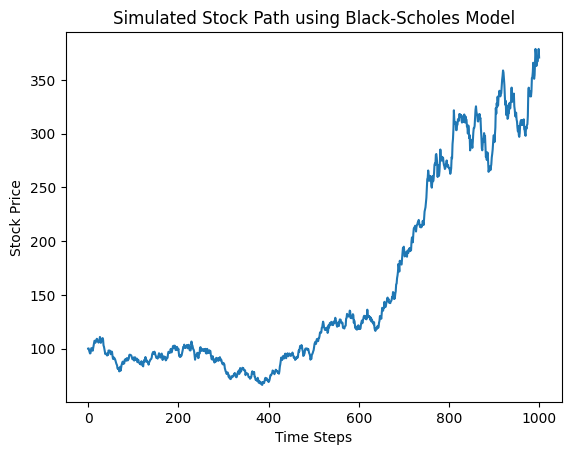

In [12]:
import numpy as np

def brownian(n, dt):
    """Simulates Brownian motion increments."""
    # Generate n standard normal variables
    dW = np.random.normal(0, np.sqrt(dt), n)
    # Cumulative sum to represent Brownian path
    W = np.cumsum(dW)
    return np.insert(W, 0, 0)  # Start from 0 for W(0)

class Black_Scholes_Model:
    
    def __init__(self, dt, interest_rate, s_0, drift, volatility):
        self.dt = dt
        self.interest_rate = interest_rate
        self.s_0 = s_0
        self.drift = drift
        self.volatility = volatility
    
    def stock_path(self, n):
        """
        Samples from the process satisfying the SDE 
        dX = μ * dt + σ * dW according to the real world measure.
        
        Returns
        ---------
        A numpy array sampling the stock price at times 0, dt, 2*dt, ..., n*dt
        """
        t = np.arange(0, (n + 1) * self.dt, self.dt)
        W = brownian(n, self.dt)  # Brownian path
        stock_prices = self.s_0 * np.exp(
            self.volatility * W + (self.drift - 0.5 * self.volatility**2) * t
        )
        return stock_prices

# Example usage
model = Black_Scholes_Model(dt=0.01, interest_rate=0.05, s_0=100, drift=0.1, volatility=0.2)
path = model.stock_path(1000)

# Plot the generated stock path
import matplotlib.pyplot as plt

plt.plot(path)
plt.title("Simulated Stock Path using Black-Scholes Model")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.show()


In [15]:

 import numpy as np
from scipy.stats import norm  # For cumulative distribution function (CDF)

class Option:
    '''A class forming the basis for various option classes.'''
    
    def __init__(self, Black_Scholes_Model, n_mat):
        self.Black_Scholes_Model = Black_Scholes_Model
        self.n_mat = n_mat  # Maturity time in time steps

    def Monte_Carlo_pricer(self, Num_Trials):
        '''A function for pricing options using Monte Carlo.
        
        Arguments:
        ----------
        Num_Trials: int
            The number of Monte Carlo trials/simulations.
        
        Returns:
        --------
        A tuple:
            (Monte Carlo mean of the contract function, standard error)
        '''
        dt = self.Black_Scholes_Model.dt
        r = self.Black_Scholes_Model.interest_rate
        
        samples = np.zeros(Num_Trials)
        
        for i in range(Num_Trials):
            # Simulate a risk-neutral stock path
            stock_path = self.Black_Scholes_Model.risk_neutral_stock_path(self.n_mat)
            # Compute discounted payoff of the option contract
            discounted_payoff = np.exp(-r * dt * self.n_mat) * self.contract(stock_path)
            samples[i] = discounted_payoff
        
        # Calculate the Monte Carlo mean and standard error
        mean = np.mean(samples)
        std_err = np.std(samples, ddof=1) / np.sqrt(Num_Trials)
        
        return mean, std_err

class European_call_option(Option):
    '''Class representing a European call option, inheriting from the Option class.'''
    
    def __init__(self, Black_Scholes_Model, n_mat, strike_price):
        super().__init__(Black_Scholes_Model, n_mat)  # Call the parent constructor
        self.strike_price = strike_price  # Option strike price

    def contract(self, stock_prices):
        '''Defines the payoff of a European call option at maturity.'''
        payoff = max(stock_prices[-1] - self.strike_price, 0)
        return payoff

    def exact_pricer(self):
        '''Calculates the exact price of the European call option using the Black-Scholes formula.'''
        sigma = self.Black_Scholes_Model.volatility
        s = self.Black_Scholes_Model.s_0
        r = self.Black_Scholes_Model.interest_rate
        K = self.strike_price
        T = self.n_mat * self.Black_Scholes_Model.dt  # Total time to maturity
        
        # Compute d1 and d2 for the Black-Scholes formula
        d1 = (np.log(s / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        # Use the cumulative distribution function (CDF) from scipy.stats.norm
        N_d1 = norm.cdf(d1)
        N_d2 = norm.cdf(d2)
        
        # Black-Scholes formula for a European call option
        call_price = s * N_d1 - np.exp(-r * T) * K * N_d2
        return call_price

# Example usage
model = Black_Scholes_Model(dt=0.01, interest_rate=0.05, s_0=100, drift=0.1, volatility=0.2)
call_option = European_call_option(model, n_mat=100, strike_price=110)

# Monte Carlo pricing
mc_price, std_err = call_option.Monte_Carlo_pricer(Num_Trials=10000)
print(f"Monte Carlo price: {mc_price}, Standard Error: {std_err}")

# Exact Black-Scholes price
exact_price = call_option.exact_pricer()
print(f"Exact Black-Scholes price: {exact_price}")



Monte Carlo price: 5.963914417599582, Standard Error: 0.11722065180630181
Exact Black-Scholes price: 6.040088129724239


In [21]:
import numpy as np

class Option:
    def __init__(self, Black_Scholes_Model, n_mat):
        self.Black_Scholes_Model = Black_Scholes_Model
        self.n_mat = n_mat

# Asian Call Option
class AsianCallOption(Option):
    def __init__(self, Black_Scholes_Model, n_mat, strike_price):
        super().__init__(Black_Scholes_Model, n_mat)
        self.strike_price = strike_price

    def contract(self, stock_prices):
        average_price = np.mean(stock_prices)
        return max(average_price - self.strike_price, 0)

# Up-and-Out Call Option
class UpAndOutCallOption(Option):
    def __init__(self, Black_Scholes_Model, n_mat, strike_price, barrier_price):
        super().__init__(Black_Scholes_Model, n_mat)
        self.strike_price = strike_price
        self.barrier_price = barrier_price

    def contract(self, stock_prices):
        if any(price >= self.barrier_price for price in stock_prices):
            return 0
        return max(stock_prices[-1] - self.strike_price, 0)

# Down-and-Out Call Option
class DownAndOutCallOption(Option):
    def __init__(self, Black_Scholes_Model, n_mat, strike_price, barrier_price):
        super().__init__(Black_Scholes_Model, n_mat)
        self.strike_price = strike_price
        self.barrier_price = barrier_price

    def contract(self, stock_prices):
        if any(price <= self.barrier_price for price in stock_prices):
            return 0
        return max(stock_prices[-1] - self.strike_price, 0)

# Double Barrier Out Call Option
class DoubleBarrierOutCallOption(Option):
    def __init__(self, Black_Scholes_Model, n_mat, strike_price, upper_barrier, lower_barrier):
        super().__init__(Black_Scholes_Model, n_mat)
        self.strike_price = strike_price
        self.upper_barrier = upper_barrier
        self.lower_barrier = lower_barrier

    def contract(self, stock_prices):
        if any(price <= self.lower_barrier or price >= self.upper_barrier for price in stock_prices):
            return 0
        return max(stock_prices[-1] - self.strike_price, 0)

# Lookback European Call Option
class LookbackEuropeanCallOption(Option):
    def __init__(self, Black_Scholes_Model, n_mat, strike_price):
        super().__init__(Black_Scholes_Model, n_mat)
        self.strike_price = strike_price

    def contract(self, stock_prices):
        max_price = np.max(stock_prices)
        return max(max_price - self.strike_price, 0)


In [24]:
import numpy as np
from scipy.special import erf  # Import error function

def brownian(n, dt):
    """A function to sample a Brownian motion at discrete times.
    
    Arguments
    ---------
    n : int
        Number of steps being taken.
    dt : float
        Size of each step.
    
    Returns
    -------
    numpy.ndarray
        A numpy array sampling the Brownian motion at times 0, dt, 2*dt, ..., n*dt.
    """
    # Generate random numbers from normal distribution with variance sqrt(dt)
    out = np.random.normal(scale=np.sqrt(dt), size=n + 1)
    out[0] = 0  # Initial value of Brownian motion is 0

    # Cumulative sum to generate a sample Brownian path
    out = np.cumsum(out)
    
    return out      

def N(x):
    """Returns the cumulative distribution function for N(0,1) evaluated at x.
    
    Arguments
    ---------
    x : float
        The point at which to evaluate the CDF.
    
    Returns
    -------
    float
        The value of the CDF for a standard normal distribution at x.
    """
    # CDF for the standard normal distribution
    out = 0.5 * (1 + erf(x / np.sqrt(2)))    
    return out

def main():
    # Example usage of brownian and N functions
    n = 100  # Number of steps
    dt = 0.01  # Size of each step
    path = brownian(n, dt)

    print("Sample Brownian path:", path)
    print("CDF at x = 1:", N(1))

if __name__ == "__main__":
    main()


Sample Brownian path: [ 0.00000000e+00  2.12186627e-01  1.54367255e-01  1.31268076e-01
  1.66785029e-01  1.12221124e-01  8.29583535e-02  1.74966296e-01
 -4.38441919e-02  9.09100318e-02  8.45224140e-02 -4.65498529e-03
 -1.18136639e-01 -1.59142322e-01 -9.56922814e-02 -1.65261723e-01
 -9.27924893e-02 -1.39987250e-01 -4.78246619e-02 -8.11819471e-02
  1.30668182e-02  1.07812277e-01  1.42004989e-01  7.45422213e-02
  1.16221576e-01  2.03524151e-01  2.49671063e-01  6.66650054e-02
  2.02932272e-01  2.21261916e-01  1.53759493e-01  1.62262644e-01
  3.89467714e-01  5.08454510e-01  4.96085916e-01  5.28526473e-01
  4.30043190e-01  2.42666052e-01  1.56565958e-01  8.27218968e-02
  1.39117109e-01  1.13991558e-01 -2.78195417e-02 -2.43384259e-02
  2.10062694e-04 -8.95021822e-02  5.07593196e-02 -6.62248247e-02
  1.18922849e-02  6.09114557e-02  1.53601191e-01  3.06371465e-01
  2.23559099e-01  1.93384635e-01  8.44947849e-02  1.06280062e-01
 -1.73680444e-02  9.23161805e-02  2.23917197e-01  2.61862212e-01
  2

In [27]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt 

def main():
    
    r = 0.05    #The interest rate
    s_0 = 1     #The inital stock price
    drift = 0.1   #The drift, \mu, of the stock
    volatility = 0.2    #The volatility, \sigma, of the stock
    
    dt = 1/365  #The time discretization of the financial model  
    n_mat = 365 #time periods until maturity
    
    #The option parameters
    strike_price = 1.1
    upper_barrier = 1.3
    lower_barrier = 0.95
    
    model = Black_Scholes_Model(dt, r, s_0, drift, volatility)
    
    euro_stock_option = European_call_option(model, n_mat, strike_price)
    asian_stock_option = Asian_call_option(model, n_mat, strike_price)
    up_and_out_stock_option = up_and_out_call_option(model, n_mat, strike_price, upper_barrier)
    down_and_out_stock_option = down_and_out_call_option(model, n_mat, strike_price, lower_barrier)
    double_barrier_out_stock_option = double_barrier_out_call_option(model, n_mat, strike_price, upper_barrier, lower_barrier)
    lookback_option = lookback_European_call_option(model, n_mat, strike_price)
    
    Num_trials = 10000
    
    
    price_1, error_1 = euro_stock_option.Monte_Carlo_pricer(Num_trials)
    price_2, error_2 = asian_stock_option.Monte_Carlo_pricer(Num_trials)
    price_3, error_3 = up_and_out_stock_option.Monte_Carlo_pricer(Num_trials)
    price_4, error_4 = down_and_out_stock_option.Monte_Carlo_pricer(Num_trials)
    price_5, error_5 = double_barrier_out_stock_option.Monte_Carlo_pricer(Num_trials)
    price_6, error_6 = lookback_option.Monte_Carlo_pricer(Num_trials)
    
    print("-----------------------------")
    print("Parameters")
    print("-----------------------------")
    print(f"Initial Stock Price: {s_0}")
    print(f"Interest Rate: {r}")
    print(f"Drift: {drift}")
    print(f"Volatility: {volatility}")
    print(f"Time to Maturity: {n_mat*dt}")
    print(f"Strike Price: {strike_price}")
    print(f"Upper Barrier: {upper_barrier}")
    print(f"Lower Barrier: {lower_barrier}")
    print("-----------------------------")
    print(f"Monte-Carlo prices with {Num_trials} trials")
    print("-----------------------------")
    print(f"The European Call Option price is: {round(price_1,5)}   (standard error: {round(error_1,5)})")
    print(f"The Asian Call Option price is: {round(price_2,5)}   (standard error: {round(error_2,5)})")
    print(f"The Up-And-Out Barrier Option price is: {round(price_3,5)}   (standard error: {round(error_3,5)})")
    print(f"The Down-And-Out Barrier Option price is: {round(price_4,5)}   (standard error: {round(error_4,5)})")
    print(f"The Double Barrier Option price is: {round(price_5,5)}   (standard error: {round(error_5,5)})")
    print(f"The Lookback European Call Option price is: {round(price_6,5)}   (standard error: {round(error_6,5)})")
    
class Black_Scholes_Model:
    
    def __init__(self, dt, interest_rate, s_0, drift, volatility):
        self.dt = dt
        self.interest_rate = interest_rate
        self.s_0 = s_0
        self.drift = drift
        self.volatility = volatility
    
    def stock_path(self,n):
        """Samples from the process statisfying the SDE 
        $$dX = \mu dt +\simga dW$$ according to the real world measure
        
        Returns
        ---------
        A numpy array sampling the stock price at times 0, dt, 2*dt, .... , n*dt
        """
        
        t = np.arange(0, (n+0.2)*self.dt, self.dt)
        out = self.s_0*np.exp(self.volatility*brownian(n, self.dt) 
                                + (self.drift- self.volatility**2/2)*t)
        
        return out
    
    def risk_neutral_stock_path(self, n):
        """Samples from the process statisfying the SDE 
        $$dX = \mu dt +\simga dW$$ according to the real world measure
        
        Returns
        ---------
        A numpy array sampling the stock price
        from the risk neutral measure at times 0, dt, 2*dt, .... , n*dt
        """
        
        t = np.arange(0, (n+0.1)*self.dt, self.dt)
        out = self.s_0*np.exp(self.volatility*brownian(n, self.dt) 
                                + (self.interest_rate- self.volatility**2/2)*t)
        
        return out
        
class Option:
    '''A class forming the basis for the various option classes.
    '''
    def __init__(self, Black_Scholes_Model, n_mat):
            
        self.Black_Scholes_Model = Black_Scholes_Model
        self.n_mat = n_mat
        
    def Monte_Carlo_pricer(self, Num_Trials):
        '''A function for pricing options using Monte Carlo.
        
        Arguments
        ---------
        self = A option with a contract function
        Num_trails = a integer, the number of samples
        
        Returns
        ---------
       A tuple where the first component is the Monte Carlo mean of the contract 
       fucntion and the second component is the standard error.
        '''
        
        dt = self.Black_Scholes_Model.dt 
        r = self.Black_Scholes_Model.interest_rate
        
        samples = np.zeros(Num_Trials)
         
        
        for _ in range(Num_Trials):
            samples[_] = np.exp(-dt*self.n_mat*r)*self.contract(self.Black_Scholes_Model.risk_neutral_stock_path(self.n_mat))
       
        mean = np.sum(samples)/Num_Trials
        var = np.sum((samples - mean)**2)
        
        return mean, np.sqrt(var/(Num_Trials - 1)**2)
    
#Defining various options via inheritance from the Options class. 

class European_call_option(Option):
    
    def __init__(self, Black_Scholes_Model, n_mat, strike_price):
        Option.__init__(self, Black_Scholes_Model, n_mat)
        self.strike_price = strike_price   
        
    def contract(self, stock_prices):
        
        if stock_prices[-1] > self.strike_price:
            return stock_prices[-1] - self.strike_price
        else:
            return 0
        
    def exact_pricer(self):
        
        sigma = self.Black_Scholes_Model.volatility
        s = self.Black_Scholes_Model.s_0
        r = self.Black_Scholes_Model.interest_rate
        K = self.strike_price
        T = self.n_mat*self.Black_Scholes_Model.dt
        
        d_1 = (1/(sigma*np.sqrt(T)))*(np.log(s/K) + (r + sigma**2/2)*T)
        d_2 = d_1 - sigma*np.sqrt(T)
        
        return s*N(d_1) - np.exp(-r*T)*K*N(d_2)
    
class Asian_call_option(Option):

    def __init__(self, Black_Scholes_Model, n_mat, strike_price):
        Option.__init__(self, Black_Scholes_Model, n_mat)
        self.strike_price = strike_price
        
    def contract(self, stock_prices):
        
        average_price = np.sum(stock_prices)/self.n_mat
        
        if average_price > self.strike_price:
            return average_price - self.strike_price
        else:
            return 0
        
class up_and_out_call_option(Option):
    
    def __init__(self, Black_Scholes_Model, n_mat, strike_price, barrier_price):
        Option.__init__(self, Black_Scholes_Model, n_mat)
        self.barrier_price = barrier_price
        self.strike_price = strike_price
        
    def contract(self, stock_prices):
        
        for price in stock_prices:
            if price > self.barrier_price:
                return 0
            
        if stock_prices[-1] > self.strike_price:
            return stock_prices[-1] - self.strike_price
        else:
            return 0
        
class down_and_out_call_option(Option):
    
    def __init__(self, Black_Scholes_Model, n_mat, strike_price, barrier_price):
        Option.__init__(self, Black_Scholes_Model, n_mat)
        self.barrier_price = barrier_price
        self.strike_price = strike_price
        
    def contract(self, stock_prices):
        
        for price in stock_prices:
            if price < self.barrier_price:
                return 0
            
        if stock_prices[-1] > self.strike_price:
            return stock_prices[-1] - self.strike_price
        else:
            return 0

class double_barrier_out_call_option(Option):
    
    def __init__(self, Black_Scholes_Model, n_mat, strike_price, upper_barrier, lower_barrier):
        Option.__init__(self, Black_Scholes_Model, n_mat)
        self.strike_price = strike_price
        self.upper_barrier = upper_barrier
        self.lower_barrier = lower_barrier
        
    def contract(self, stock_prices):
        
        for price in stock_prices:
            if price < self.lower_barrier or price > self.upper_barrier:
                return 0
            
        if stock_prices[-1] > self.strike_price:
            return stock_prices[-1] - self.strike_price
        else:
            return 0
        
class lookback_European_call_option(Option):
    
    def __init__(self, Black_Scholes_Model, n_mat, strike_price):
        Option.__init__(self, Black_Scholes_Model, n_mat)
        self.strike_price = strike_price
        
        
    def contract(self, stock_prices):
        
        max_price = np.max(stock_prices)
        
        if max_price > self.strike_price:
            return max_price - self.strike_price
        else:
            return 0
        
#Some auxillary functions
                
def brownian(n, dt):
    """ A function to sample a Brownian motion at discrete times
    
    Arguments
    ---------
    n = number of steps being taken
    dt = size of steps
    
    Returns
    -------
    A numpy array sampling the Browian motion at times 0, dt, 2*dt, ... , n*dt.
    """
    #Gnerate random numbers from normal distribution with variance sqrt(dt)
    out = np.random.normal(scale = np.sqrt(dt), size = n+1)
    out[0] = 0
    
    #Cumlative sum to give sample of Brownian path
    out = np.cumsum(out)
    
    return out      

def N(x):
    """Returns the cumulative distribution function for N(0,1) evaluated at x.
    """
    out = (1/2)*(1+erf(x/np.sqrt(2)))    
    
    return out
    

if __name__ == "__main__": main()

<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Arham\AppData\Local\Temp\ipykernel_32588\3344019805.py:70: SyntaxWarning: invalid escape sequence '\m'
  """Samples from the process statisfying the SDE
C:\Users\Arham\AppData\Local\Temp\ipykernel_32588\3344019805.py:85: SyntaxWarning: invalid escape sequence '\m'
  """Samples from the process statisfying the SDE


-----------------------------
Parameters
-----------------------------
Initial Stock Price: 1
Interest Rate: 0.05
Drift: 0.1
Volatility: 0.2
Time to Maturity: 1.0
Strike Price: 1.1
Upper Barrier: 1.3
Lower Barrier: 0.95
-----------------------------
Monte-Carlo prices with 10000 trials
-----------------------------
The European Call Option price is: 0.06036   (standard error: 0.00117)
The Asian Call Option price is: 0.02084   (standard error: 0.00049)
The Up-And-Out Barrier Option price is: 0.01088   (standard error: 0.00031)
The Down-And-Out Barrier Option price is: 0.03843   (standard error: 0.00103)
The Double Barrier Option price is: 0.00427   (standard error: 0.0002)
The Lookback European Call Option price is: 0.10962   (standard error: 0.00142)
